In [7]:
import json
import mysql
from mysql.connector import connect, Error
import numpy as np
import pandas as pd

from IPython.display import display_html
from itertools import chain,cycle
from IPython.core.display import display, HTML

In [8]:
# Acknowledgment: adapted from
# https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align:center">{title}</h2>'
        html_str+=df.to_html(index=False).replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [16]:
# Acknowledgment: taken from
# https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
import matplotlib
import matplotlib.pyplot as plt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
#     cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [3]:
civ_mapping = [
    {
        "id": 0,
        "string": "Abbasid"
    },
    {
        "id": 1,
        "string": "Chinese"
    },
    {
        "id": 2,
        "string": "Delhi"
    },
    {
        "id": 3,
        "string": "English"
    },
    {
        "id": 4,
        "string": "French"
    },
    {
        "id": 5,
        "string": "HRE"
    },
    {
        "id": 6,
        "string": "Mongols"
    },
    {
        "id": 7,
        "string": "Rus"
    }
]
map_type_mapping = [
    {
        "id": 0,
        "string": "Dry Arabia"
    },
    {
        "id": 1,
        "string": "Lipany"
    },
    {
        "id": 2,
        "string": "High View"
    },
    {
        "id": 3,
        "string": "Mountain Pass"
    },
    {
        "id": 4,
        "string": "Ancient Spires"
    },
    {
        "id": 5,
        "string": "Danube River"
    },
    {
        "id": 6,
        "string": "Black Forest"
    },
    {
        "id": 7,
        "string": "Mongolian Heights"
    },
    {
        "id": 8,
        "string": "Altai"
    },
    {
        "id": 9,
        "string": "Confluence"
    },
    {
        "id": 10,
        "string": "French Pass"
    },
    {
        "id": 11,
        "string": "Hill and Dale"
    },
    {
        "id": 12,
        "string": "King of Hill"
    },
    {
        "id": 13,
        "string": "Warring Islands"
    },
    {
        "id": 14,
        "string": "Archipelago"
    },
    {
        "id": 15,
        "string": "Nagari"
    },
    {
        "id": 16,
        "string": "Boulder Bay"
    }
]

In [6]:
con = connect(
        host='localhost',
        user='root',
        password='pass',
        db='aoe4_stats',
        port=3306
    )
cursor = con.cursor()

# Winrates

In [10]:
def get_winrate_entry(civ_map_entry):
    cursor.execute(f'''
    WITH no_mirror_match_record AS (SELECT * FROM match_record WHERE winning_civ != losing_civ AND game_version = 8324)
    SELECT
        SUM(CASE WHEN winning_civ = {civ_map_entry['id']} THEN 1 ELSE 0 END) AS wins,
        SUM(CASE WHEN losing_civ = {civ_map_entry['id']} THEN 1 ELSE 0 END) AS losses
    FROM no_mirror_match_record;
    ''')
    row = cursor.fetchone()
    return {'Civ': civ_map_entry["string"], 'Wins': int(row[0]), 'Losses': int(row[1])}

def get_winrate_entry_for_map(civ_map_entry, map_id):
    cursor.execute(f'''
    WITH no_mirror_match_record AS (SELECT * FROM match_record WHERE winning_civ != losing_civ AND map_type={map_id} AND game_version = 8324)
    SELECT
        SUM(CASE WHEN winning_civ = {civ_map_entry['id']} THEN 1 ELSE 0 END) AS wins,
        SUM(CASE WHEN losing_civ = {civ_map_entry['id']} THEN 1 ELSE 0 END) AS losses
    FROM no_mirror_match_record;
    ''')
    row = cursor.fetchone()
    return {'Civ': civ_map_entry["string"], 'Wins': int(row[0]), 'Losses': int(row[1])}

def get_winrates_df():
    civ_winrates = [get_winrate_entry(cm) for cm in civ_mapping]
    winrate_df = pd.DataFrame(civ_winrates, columns=['Civ', 'Wins', 'Losses'])
    winrate_df['Total'] = winrate_df['Wins'] + winrate_df['Losses']
    winrate_df['Winrate'] = winrate_df['Wins'] / winrate_df['Total']
    winrate_df = winrate_df.sort_values(by=['Winrate'], ascending=False)
    winrate_df['Winrate'] = winrate_df['Winrate'] * 100
    return winrate_df

def get_winrates_df_for_map(map_id):
    civ_winrates = [get_winrate_entry_for_map(cm, map_id) for cm in civ_mapping]
    winrate_df = pd.DataFrame(civ_winrates, columns=['Civ', 'Wins', 'Losses'])
    winrate_df['Total'] = winrate_df['Wins'] + winrate_df['Losses']
    winrate_df['Winrate'] = winrate_df['Wins'] / winrate_df['Total']
    winrate_df = winrate_df.sort_values(by=['Winrate'], ascending=False)
    winrate_df['Winrate'] = winrate_df['Winrate'] * 100
    return winrate_df

In [12]:
row1 = [0, 1, 2, 3]
row2 = [4, 5, 6, 7, 8]
row3 = [9, 10, 11, 12, 13]
row4 = [14, 15, 16]

row1_dfs = [get_winrates_df_for_map(map_id) for map_id in row1]
row1_titles = [map_type_mapping[map_id]['string'] for map_id in row1]

row2_dfs = [get_winrates_df_for_map(map_id) for map_id in row2]
row2_titles = [map_type_mapping[map_id]['string'] for map_id in row2]

row3_dfs = [get_winrates_df_for_map(map_id) for map_id in row3]
row3_titles = [map_type_mapping[map_id]['string'] for map_id in row3]

row4_dfs = [get_winrates_df_for_map(map_id) for map_id in row4]
row4_titles = [map_type_mapping[map_id]['string'] for map_id in row4]

In [14]:
pd.options.display.float_format = '{:,.2f}'.format
display(HTML("<style>.container { width:1920px !important; }</style>"))
display_side_by_side(get_winrates_df(), *row1_dfs, titles=["Total"] + row1_titles)
display_side_by_side(*row2_dfs, titles=row2_titles)
display_side_by_side(*row3_dfs, titles=row3_titles)
display_side_by_side(*row4_dfs, titles=row4_titles)

Civ,Wins,Losses,Total,Winrate
Rus,2313,2229,4542,50.92
English,1502,1475,2977,50.45
Chinese,2244,2241,4485,50.03
French,1537,1537,3074,50.00
Mongols,2501,2519,5020,49.82
HRE,1144,1169,2313,49.46
Abbasid,726,757,1483,48.95
Delhi,497,537,1034,48.07
Civ,Wins,Losses,Total,Winrate
English,143,111,254,56.30


Civ,Wins,Losses,Total,Winrate
Abbasid,85,60,145,58.62
Delhi,47,36,83,56.63
HRE,52,46,98,53.06
French,71,67,138,51.45
Chinese,109,103,212,51.42
Rus,99,98,197,50.25
Mongols,172,206,378,45.50
English,57,76,133,42.86
Civ,Wins,Losses,Total,Winrate
Delhi,58,44,102,56.86


Civ,Wins,Losses,Total,Winrate
Rus,121,84,205,59.02
English,68,53,121,56.20
Abbasid,40,33,73,54.79
French,60,53,113,53.10
HRE,57,51,108,52.78
Chinese,110,116,226,48.67
Mongols,121,160,281,43.06
Delhi,31,58,89,34.83
Civ,Wins,Losses,Total,Winrate
Delhi,38,30,68,55.88


Civ,Wins,Losses,Total,Winrate
Mongols,53,33,86,61.63
French,61,54,115,53.04
Chinese,29,26,55,52.73
Delhi,3,3,6,50.00
Rus,46,53,99,46.46
English,13,16,29,44.83
HRE,23,36,59,38.98
Abbasid,8,15,23,34.78
Civ,Wins,Losses,Total,Winrate
HRE,65,49,114,57.02


# Matchups

In [15]:
def get_matchup_winrate_entry(civ_id):
    cursor.execute(f'''
    WITH match_record_v_8324 AS (
        SELECT * FROM match_record WHERE game_version = 8324
    )
    SELECT
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 0 THEN 1 ELSE 0 END) AS wins_vs_0,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 0 THEN 1 ELSE 0 END) AS losses_vs_0,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 1 THEN 1 ELSE 0 END) AS wins_vs_1,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 1 THEN 1 ELSE 0 END) AS losses_vs_1,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 2 THEN 1 ELSE 0 END) AS wins_vs_2,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 2 THEN 1 ELSE 0 END) AS losses_vs_2,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 3 THEN 1 ELSE 0 END) AS wins_vs_3,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 3 THEN 1 ELSE 0 END) AS losses_vs_3,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 4 THEN 1 ELSE 0 END) AS wins_vs_4,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 4 THEN 1 ELSE 0 END) AS losses_vs_4,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 5 THEN 1 ELSE 0 END) AS wins_vs_5,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 5 THEN 1 ELSE 0 END) AS losses_vs_5,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 6 THEN 1 ELSE 0 END) AS wins_vs_6,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 6 THEN 1 ELSE 0 END) AS losses_vs_6,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 7 THEN 1 ELSE 0 END) AS wins_vs_7,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 7 THEN 1 ELSE 0 END) AS losses_vs_7
    FROM match_record_v_8324;
    ''')
    matchup_winrates = list(cursor.fetchone())
    # Remove duplicates for mirror
    matchup_winrates[civ_id * 2] = matchup_winrates[civ_id * 2] / 2
    matchup_winrates[civ_id * 2 + 1] = matchup_winrates[civ_id * 2 + 1] / 2
    return [float(wr) for wr in matchup_winrates]

def get_matchup_winrate_entry_by_map(civ_id, map_id):
    cursor.execute(f'''
    WITH match_record_v_8324 AS (
        SELECT * FROM match_record WHERE game_version = 8324 AND map_type = {map_id}
    )
    SELECT
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 0 THEN 1 ELSE 0 END) AS wins_vs_0,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 0 THEN 1 ELSE 0 END) AS losses_vs_0,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 1 THEN 1 ELSE 0 END) AS wins_vs_1,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 1 THEN 1 ELSE 0 END) AS losses_vs_1,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 2 THEN 1 ELSE 0 END) AS wins_vs_2,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 2 THEN 1 ELSE 0 END) AS losses_vs_2,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 3 THEN 1 ELSE 0 END) AS wins_vs_3,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 3 THEN 1 ELSE 0 END) AS losses_vs_3,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 4 THEN 1 ELSE 0 END) AS wins_vs_4,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 4 THEN 1 ELSE 0 END) AS losses_vs_4,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 5 THEN 1 ELSE 0 END) AS wins_vs_5,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 5 THEN 1 ELSE 0 END) AS losses_vs_5,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 6 THEN 1 ELSE 0 END) AS wins_vs_6,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 6 THEN 1 ELSE 0 END) AS losses_vs_6,
        SUM(CASE WHEN winning_civ = {civ_id} AND losing_civ = 7 THEN 1 ELSE 0 END) AS wins_vs_7,
        SUM(CASE WHEN losing_civ = {civ_id} AND winning_civ = 7 THEN 1 ELSE 0 END) AS losses_vs_7
    FROM match_record_v_8324;
    ''')
    matchup_winrates = list(cursor.fetchone())
    # Remove duplicates for mirror
    matchup_winrates[civ_id * 2] = matchup_winrates[civ_id * 2] / 2
    matchup_winrates[civ_id * 2 + 1] = matchup_winrates[civ_id * 2 + 1] / 2
    return [float(wr) for wr in matchup_winrates]

def get_matchup_df():
    civ_matchup_winrates = [[cm["string"]]+get_matchup_winrate_entry(cm["id"]) for cm in civ_mapping]
    matchup_df = pd.DataFrame(civ_matchup_winrates, columns=['Civ'] + 
                              list(np.array([[f'wins_vs_{i}', f'losses_vs_{i}'] for i in range(8)]).flatten()))
    for i in range(8):
        matchup_df[f'total_vs_{i}'] = matchup_df[f'wins_vs_{i}'] + matchup_df[f'losses_vs_{i}']
        matchup_df[f'winrate_vs_{i}'] = matchup_df[f'wins_vs_{i}'] / matchup_df[f'total_vs_{i}']
    return matchup_df
        
def get_matchup_df_by_map(map_id):
    civ_matchup_winrates = [[cm["string"]]+get_matchup_winrate_entry_by_map(cm["id"], map_id) for cm in civ_mapping]
    matchup_df = pd.DataFrame(civ_matchup_winrates, columns=['Civ'] + 
                              list(np.array([[f'wins_vs_{i}', f'losses_vs_{i}'] for i in range(8)]).flatten()))
    for i in range(8):
        matchup_df[f'total_vs_{i}'] = matchup_df[f'wins_vs_{i}'] + matchup_df[f'losses_vs_{i}']
        matchup_df[f'winrate_vs_{i}'] = matchup_df[f'wins_vs_{i}'].div(matchup_df[f'total_vs_{i}'].where(matchup_df[f'total_vs_{i}'] != 0, np.nan))
    return matchup_df


In [20]:
matchup_dfs = [get_matchup_df()] + [get_matchup_df_by_map(m) for m in range(17)]
titles=["Total"] + [m['string'] for m in map_type_mapping]
source_civ_labels = matchup_dfs[0]['Civ'].tolist()
vs_civ_labels = [f"Vs {c}" for c in source_civ_labels]

<string>:6: UserWarning: Warning: converting a masked element to nan.
C:\Users\Artem\Python7\lib\site-packages\numpy\ma\core.py:717: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
C:\Users\Artem\Python7\lib\site-packages\matplotlib\ticker.py:431: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  return self.fmt.format(x=x, pos=pos)


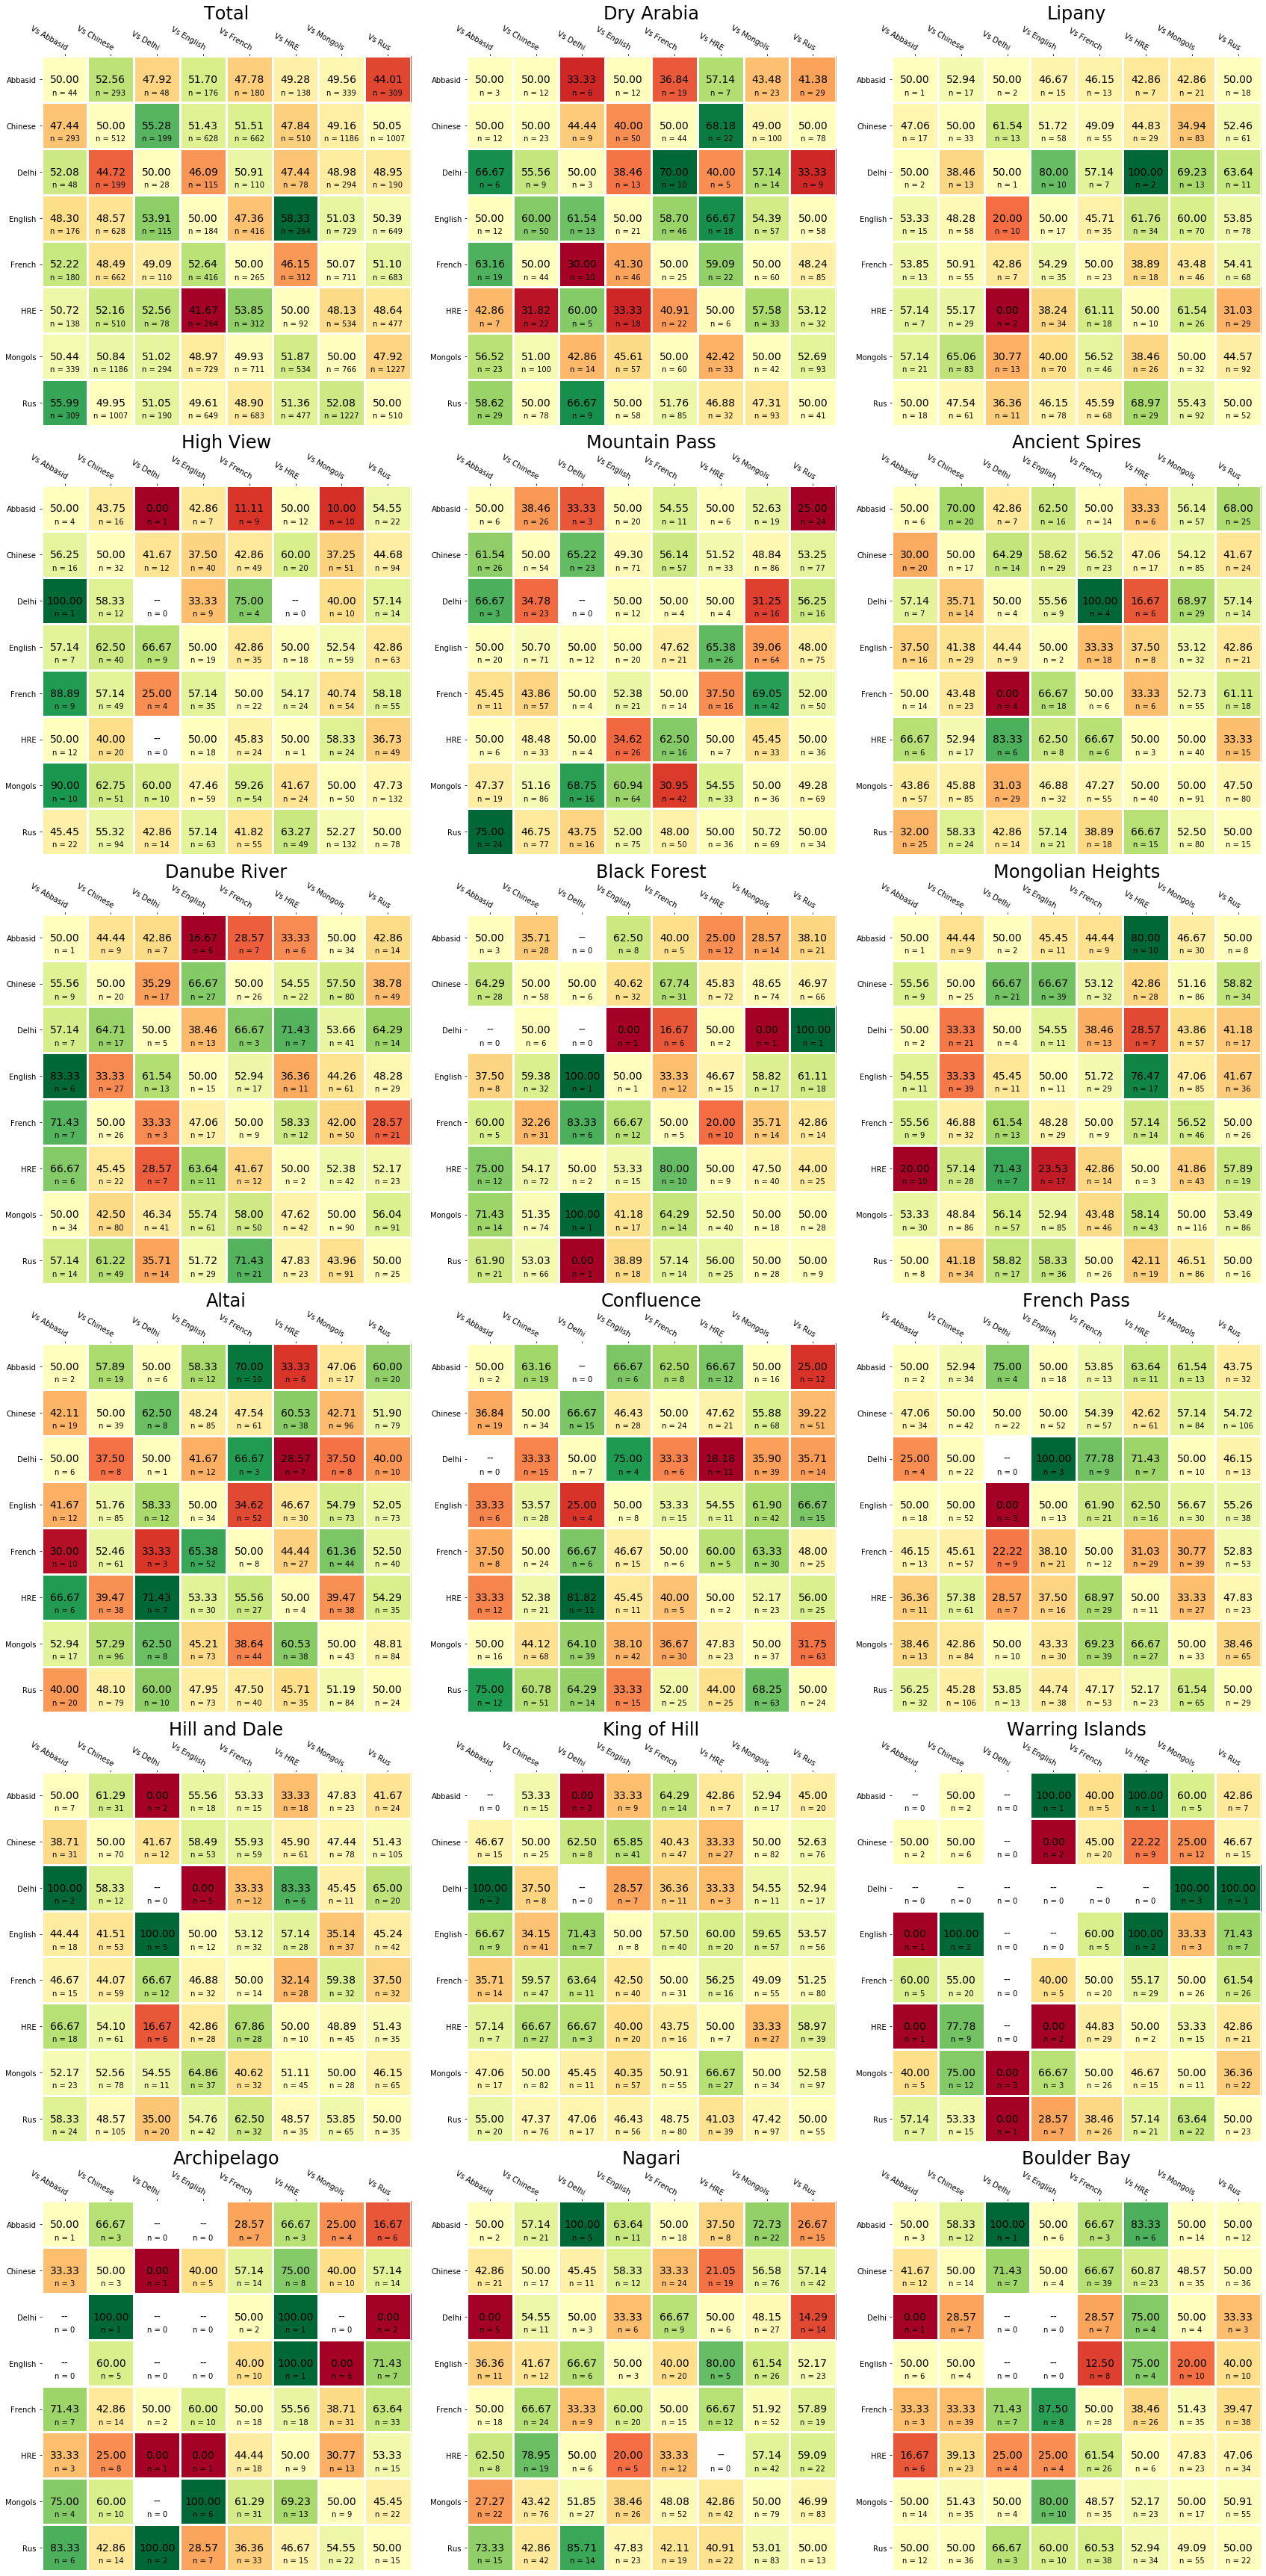

In [21]:
fig, axes = plt.subplots(6, 3, figsize=(24, 48))
axes = [a for ax_list in axes for a in ax_list]

for c in range(18):
    vs_df = matchup_dfs[c][[f'winrate_vs_{i}' for i in range(8)]] * 100
    count_df = matchup_dfs[c][[f'total_vs_{i}' for i in range(8)]]
    axes[c].set_title(titles[c], fontsize=24)
    im = heatmap(vs_df.to_numpy(dtype=float).round(2), source_civ_labels, vs_civ_labels, ax=axes[c], cmap="RdYlGn")
    annotate_heatmap(im, valfmt="{x:.2f}", size=14, textcolors=["black", "black"])
    annotate_heatmap(count_df.to_numpy(dtype=int), valfmt="\n\n\nn = {x}", size=10, textcolors=["black", "black"])


plt.tight_layout()
plt.show()

# Pickrates

In [22]:
def get_civ_pickrates(civ_map_entry):
    cursor.execute(f'''
    WITH match_record_v_8324 AS (
        SELECT * FROM match_record WHERE game_version = 8324
    ),
    civ_picks AS (
        SELECT match_id, player1_profile_id AS profile_id, player1_civ AS civ 
        FROM match_record_v_8324 
        WHERE player1_profile_id IN (SELECT profile_id FROM queried_player)
            UNION
        SELECT match_id, player2_profile_id AS profile_id, player2_civ AS civ 
        FROM match_record_v_8324
        WHERE player2_profile_id IN (SELECT profile_id FROM queried_player)
    )
    SELECT COUNT(profile_id) AS picked_count FROM civ_picks WHERE civ={civ_map_entry["id"]} GROUP BY profile_id ORDER BY picked_count;
    ''')
    civ_pickrates = np.array(cursor.fetchall()).flatten()
    return [
        civ_map_entry["string"], 
        np.sum(civ_pickrates), 
        np.quantile(civ_pickrates, .25), 
        np.quantile(civ_pickrates, .5), 
        np.quantile(civ_pickrates, .75)
    ]

def get_civ_pickrates_by_map(civ_map_entry, map_id):
    cursor.execute(f'''
    WITH match_record_v_8324 AS (
        SELECT * FROM match_record WHERE game_version = 8324 AND map_type = {map_id}
    ),
    civ_picks AS (
        SELECT match_id, player1_profile_id AS profile_id, player1_civ AS civ 
        FROM match_record_v_8324 
        WHERE player1_profile_id IN (SELECT profile_id FROM queried_player)
            UNION
        SELECT match_id, player2_profile_id AS profile_id, player2_civ AS civ 
        FROM match_record_v_8324
        WHERE player2_profile_id IN (SELECT profile_id FROM queried_player)
    )
    SELECT COUNT(profile_id) AS picked_count FROM civ_picks WHERE civ={civ_map_entry["id"]} GROUP BY profile_id ORDER BY picked_count;
    ''')
    civ_pickrates = np.array(cursor.fetchall()).flatten()
    return [
        civ_map_entry["string"], 
        np.sum(civ_pickrates), 
        np.quantile(civ_pickrates, .25), 
        np.quantile(civ_pickrates, .5), 
        np.quantile(civ_pickrates, .75)
    ]

def get_pickrate_statistics_df():
    civ_pickrates = [get_civ_pickrates(cm) for cm in civ_mapping]
    pickrate_df = pd.DataFrame(civ_pickrates, columns=['Civ', 'Picks', '25th Quantile', '50th Quantile', '90th Quantile'])
    pickrate_df = pickrate_df.sort_values(by=['Picks'], ascending=False)
    return pickrate_df

def get_pickrate_statistics_df_by_map(map_id):
    civ_pickrates = [get_civ_pickrates_by_map(cm, map_id) for cm in civ_mapping]
    pickrate_df = pd.DataFrame(civ_pickrates, columns=['Civ', 'Picks', '25th Quantile', '50th Quantile', '90th Quantile'])
    pickrate_df = pickrate_df.sort_values(by=['Picks'], ascending=False)
    return pickrate_df

In [23]:
row1_dfs = [get_pickrate_statistics_df_by_map(map_id) for map_id in row1]
row2_dfs = [get_pickrate_statistics_df_by_map(map_id) for map_id in row2]
row3_dfs = [get_pickrate_statistics_df_by_map(map_id) for map_id in row3]
row4_dfs = [get_pickrate_statistics_df_by_map(map_id) for map_id in row4]

In [24]:
display(HTML("<style>.container { width:1920px !important; }</style>"))
display_side_by_side(get_pickrate_statistics_df(), *row1_dfs, titles=["Total"] + row1_titles)
display_side_by_side(*row2_dfs, titles=row2_titles)
display_side_by_side(*row3_dfs, titles=row3_titles)
display_side_by_side(*row4_dfs, titles=row4_titles)

Civ,Picks,25th Quantile,50th Quantile,90th Quantile
Mongols,5448,3.00,7.00,18.00
Rus,4562,3.00,6.00,13.00
Chinese,4511,2.00,6.50,16.00
French,2671,1.00,3.00,9.00
English,2527,2.00,4.00,9.00
HRE,1811,1.00,3.00,9.00
Abbasid,1165,1.00,3.00,8.00
Delhi,830,1.00,2.00,5.00
Civ,Picks,25th Quantile,50th Quantile,90th Quantile
Rus,402,1.00,2.00,3.00


Civ,Picks,25th Quantile,50th Quantile,90th Quantile
Mongols,481,1.00,2.00,3.00
Chinese,186,1.00,2.00,3.00
Rus,175,1.00,1.00,2.00
Abbasid,125,1.00,1.00,3.00
French,100,1.00,1.00,2.00
English,97,1.00,1.00,2.00
HRE,72,1.00,1.00,2.00
Delhi,70,1.00,1.00,2.00
Civ,Picks,25th Quantile,50th Quantile,90th Quantile
Mongols,497,1.00,2.00,3.00


Civ,Picks,25th Quantile,50th Quantile,90th Quantile
Mongols,276,1.00,2.00,3.00
Chinese,233,1.00,1.00,3.00
Rus,186,1.00,1.00,2.00
English,98,1.00,1.00,2.00
French,95,1.00,1.00,2.00
Delhi,83,1.00,1.00,2.00
HRE,78,1.00,1.00,2.00
Abbasid,54,1.00,1.00,2.00
Civ,Picks,25th Quantile,50th Quantile,90th Quantile
Chinese,421,1.00,2.00,3.00


Civ,Picks,25th Quantile,50th Quantile,90th Quantile
French,118,1.00,1.00,2.00
Rus,106,1.00,1.00,2.00
Mongols,91,1.00,1.00,2.00
HRE,67,1.00,1.00,2.00
Chinese,57,1.00,1.00,2.00
English,20,1.00,1.00,2.00
Abbasid,15,1.00,1.00,2.00
Delhi,1,1.00,1.00,1.00
Civ,Picks,25th Quantile,50th Quantile,90th Quantile
Mongols,427,1.00,2.00,3.00
